In [1]:
"""CVAE on MNIST
"""
import argparse
import os

import chainer
import pickle
import matplotlib.pyplot as plt
from chainer import training
from chainer.training import extensions
from PIL import Image, ImageDraw
import numpy as np
import cv2

import net 
import make_random_mnist
import make_random_selfdata
from chainer import serializers
%matplotlib inline

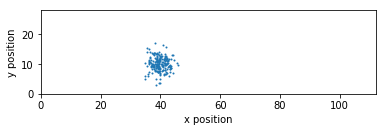

45.95229406275243
16.93068941777174


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

mu = [40, 10]
sigma = [[5, 0], [0, 5]]
values = np.random.multivariate_normal(mu, sigma, 200)
 
# 散布図
ax = plt.gca()
ax.scatter(values[:,0], values[:,1], s=1)
ax.set(ylim=(0,28), ylabel='y position', xlim=(0,28*4), xlabel='x position', aspect='equal')
plt.show()
print(max(values[:,0]))
print(max(values[:,1]))

In [3]:
# Visualize the results
def save_images(x, filename, h= 29, w=113, cols=3,rows=3):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(cols, rows, figsize=(9, 9), dpi=120, edgecolor='coral', linewidth=2)
    for ai, xi in zip(ax.ravel(), x):
        ai.imshow(xi.reshape(h, w))
    ai.set_title(filename)
    fig.savefig(filename)
    plt.show()
    
def save_onehotvec(x):
    plt.plot(x)
    plt.show()
    
def trainMyModel(model, x_train, x_test, options):
    if options.test:
        x_train, _ = chainer.datasets.split_dataset(x_train, 100)
        x_test, _ = chainer.datasets.split_dataset(x_test, 100)
    train_iter = chainer.iterators.SerialIterator(x_train, options.batchsize)
    test_iter = chainer.iterators.SerialIterator(x_test, options.batchsize,repeat=False, shuffle=False)
    
    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Initialize
    if options.initmodel:
        chainer.serializers.load_npz(options.initmodel, model)

    # Set up an updater. StandardUpdater can explicitly specify a loss function
    # used in the training with 'loss_func' option
    updater = training.updaters.StandardUpdater(train_iter, optimizer,device=options.gpu, loss_func=model.get_loss_func())

    trainer = training.Trainer(updater, (options.epoch, 'epoch'), out=options.out)
    trainer.extend(extensions.Evaluator(test_iter, model, device=options.gpu,eval_func=model.get_loss_func(k=10)))
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(20, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/rec_loss', 'validation/main/rec_loss', 'elapsed_time']))
    #trainer.extend(extensions.ProgressBar())

    if options.resume:
        chainer.serializers.load_npz(options.resume, trainer)

    # Run the training
    trainer.run()
    model.to_cpu()
    serializers.save_npz("mymodel_final.npz", model)
    return model

def testMyModel(model, x_test):
    pass

In [4]:
def load_save_random_dataset_withlabel(fname, n):
    dataset = make_random_mnist.MakeRandomMNIST()
    if os.path.exists(fname):
        with open(fname, mode='rb') as f:
            ret = pickle.load(f)
            return ret
    v = dataset.get_random_dataset_with_label(n)
    with open(fname, mode='wb') as f:
        pickle.dump(v, f)
        return v

def dispImage(img_vec):
    #title = 'Label number is ('+ str(label_x) + ',' + str(label_y) + ')' 
    fig = plt.figure()
    pixels = (img_vec * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.axis("off")
    #plt.title(title)
    plt.show()

def dispOneHotVec(img, vec, vec_size,vec_ratio):
    t_img = img.copy() # cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    #print(np.where(vec==1))
    hotvec = vec.reshape(vec_size)
    #print(hotvec.shape)
    cx, cy = np.where(hotvec == 1)
    #print(cx, cy)
    conv_img_coord_x = (cy*vec_ratio)+14
    conv_img_coord_y = (cx*vec_ratio)+14
    t_img = cv2.circle(t_img, (conv_img_coord_x,conv_img_coord_y), 1, (255, 0, 0), thickness=-1, lineType=cv2.LINE_8, shift=0)
    t_img = cv2.rectangle(t_img, (conv_img_coord_x-14,conv_img_coord_y-14), 
                          (conv_img_coord_x+14,conv_img_coord_y+14), (255,0,0), thickness=0, lineType=cv2.LINE_8, shift=0)
    fig = plt.figure() # Figureオブジェクトを作成
    ax = fig.add_subplot(1,1,1) # figに属するAxesオブジェクトを作成
    plt.imshow(t_img)
    plt.show()
def dispCropPos(img, data, label_vec_size, vec_ratio, color=(248,169,0)):
    t_img = img.copy()
    for n in range(len(data)):
        im, la = data[n]
        #print(la.shape)
        hotvec = la.reshape(label_vec_size)
        cx, cy = np.where(hotvec == 1)
        conv_img_coord_x = (cy*vec_ratio)+14
        conv_img_coord_y = (cx*vec_ratio)+14
        t_img[conv_img_coord_y, conv_img_coord_x] = color
    return t_img

def separetePosition_and_angle_probabilityMap(data, data_len, border):
    angle_map_l = len(data[0]) - border 
    pos_map = np.zeros((data_len, border), dtype=np.float32)
    angle_map = np.zeros((data_len, angle_map_l), dtype=np.float32)
    for n in range(data_len):
        pos_map[n,:] = data[n][0:border]
        angle_map[n,:] = data[n][border:]
    return pos_map, angle_map

In [5]:
def chageBrightness(data, label_vec_size):
    data_num = len(data)
    images = np.zeros((data_num, 28*28), dtype=np.float32)  
    labels = np.zeros((data_num, label_vec_size[0]*label_vec_size[1]), dtype=np.float32)  
    for i in range(data_num):
        img, label = data[i]
        rand_gain = np.random.uniform(-0.3, 0.3, (28*28))
        im = img+rand_gain
        # 0 miman
        im = np.where(im > 1, 1, im)
        # 1 izyou
        im = np.where(im < 0, 0, im)
        images[i, :] = im
        labels[i, :] = label
    return chainer.datasets.TupleDataset(images, labels)

def addGomashio(data, label_vec_size):
    size = 1
    data_num = len(data)
    images = np.zeros((data_num, 28*28), dtype=np.float32)  
    labels = np.zeros((data_num, label_vec_size[0]*label_vec_size[1]), dtype=np.float32)  
    for n in range(data_num):
        x = int(np.random.uniform(0,27))
        y = int(np.random.uniform(0,27))
        c = int(np.random.uniform(0,256))
        img, label = data[n]
        img = (img * 256).reshape((28, 28))
        img = cv2.rectangle(img, (x, y),(x+size,y+size), c, -1)
        img = img.flatten()
        images[n, :] = img/256.
        labels[n, :] = label
    return chainer.datasets.TupleDataset(images, labels)

GPU: 0
# dim z: 4
# Minibatch-size: 150
# epoch: 150

3000


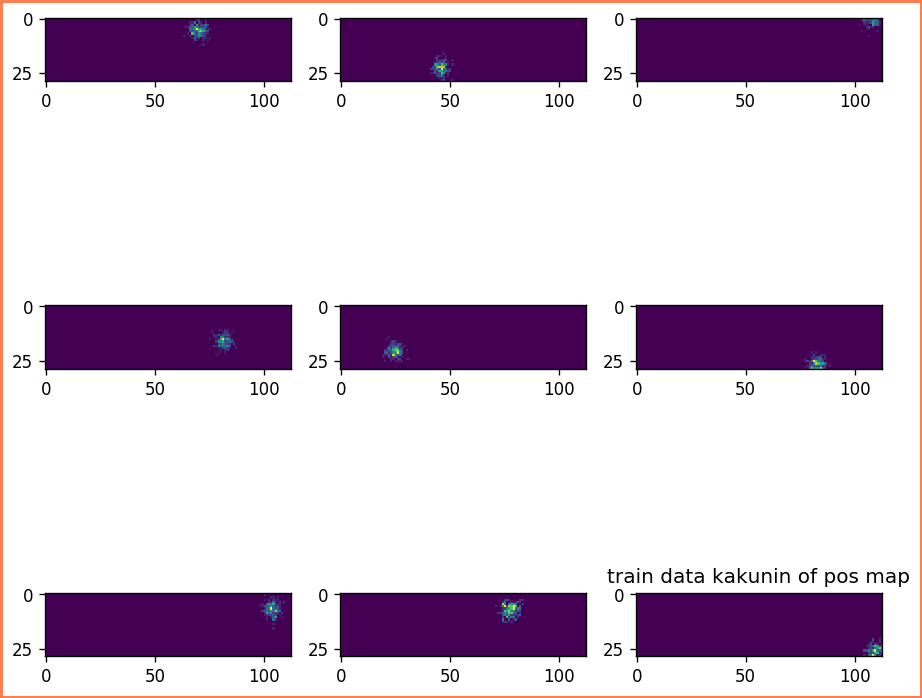

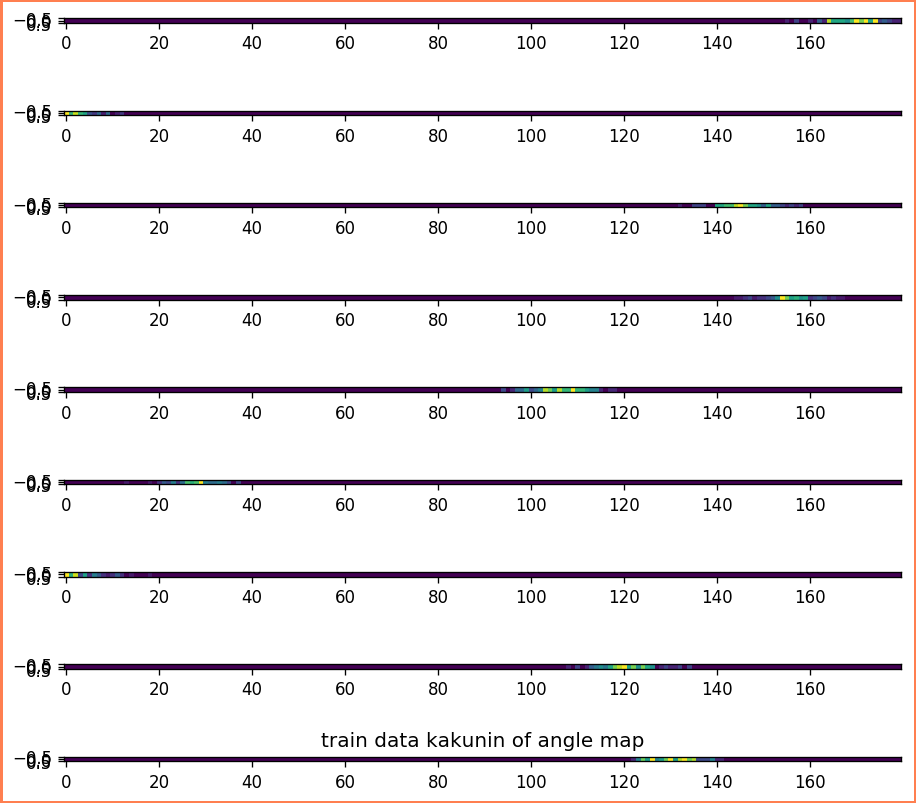

訓練データの画像


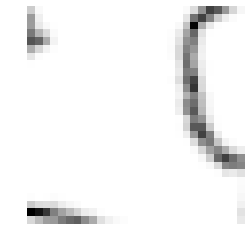

171 70 6 deg, posx, posy
回転する前の画像


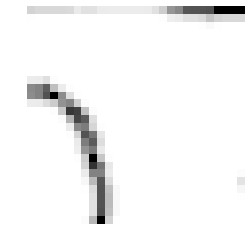

回転した画像


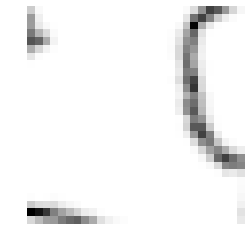

訓練データの画像


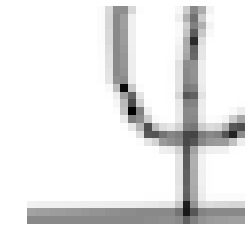

1 46 23 deg, posx, posy
回転する前の画像


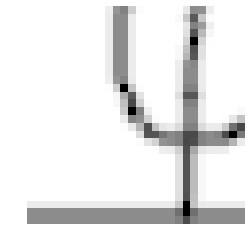

回転した画像


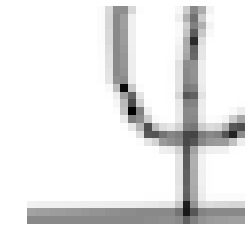

訓練データの画像


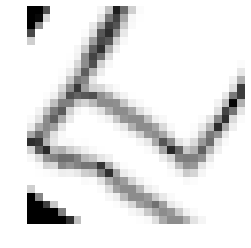

147 108 1 deg, posx, posy
回転する前の画像


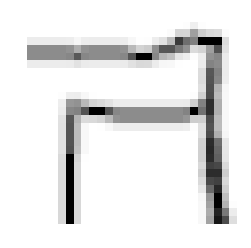

回転した画像


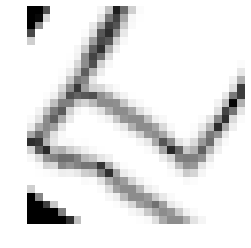

訓練データの画像


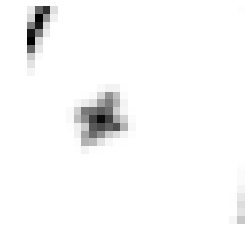

156 82 16 deg, posx, posy
回転する前の画像


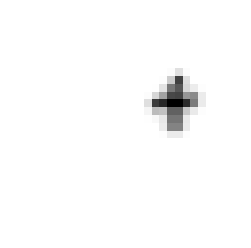

回転した画像


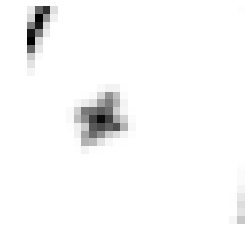

訓練データの画像


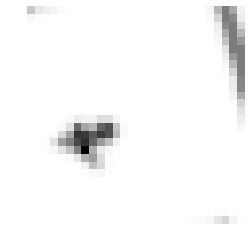

106 25 21 deg, posx, posy
回転する前の画像


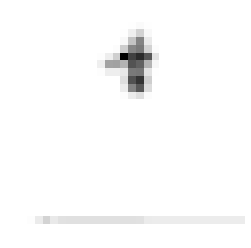

回転した画像


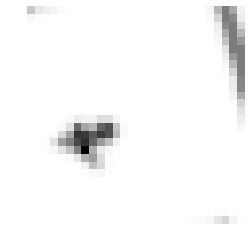

訓練データの画像


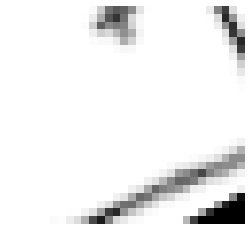

28 83 27 deg, posx, posy
回転する前の画像


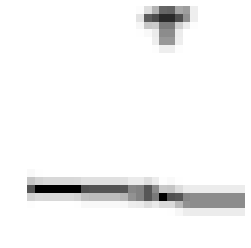

回転した画像


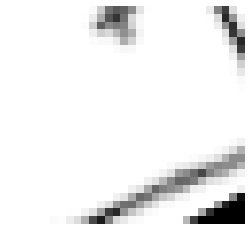

訓練データの画像


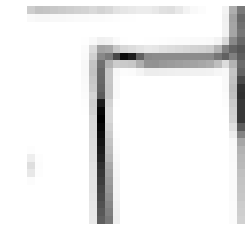

2 104 8 deg, posx, posy
回転する前の画像


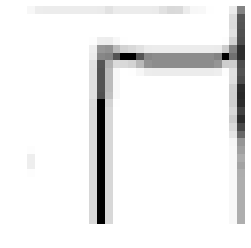

回転した画像


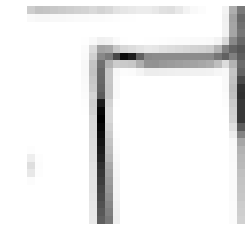

訓練データの画像


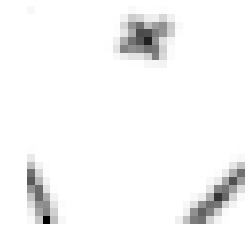

121 78 8 deg, posx, posy
回転する前の画像


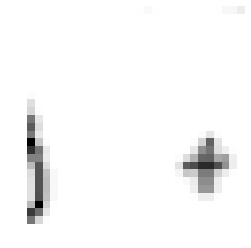

回転した画像


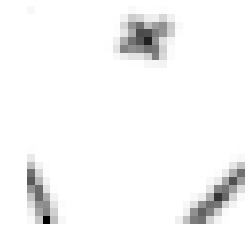

訓練データの画像


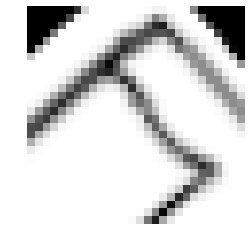

131 110 27 deg, posx, posy
回転する前の画像


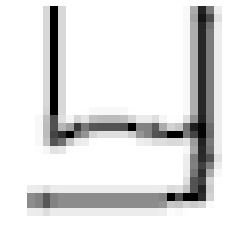

回転した画像


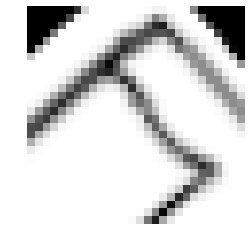

NLABEL 784
CONDITION 784
CONTEXT 3457
epoch       main/loss   validation/main/loss  main/rec_loss  validation/main/rec_loss  elapsed_time
1           408.376     163.904               393.442        162.206                   1.07293       
2           159.171     158.193               157.098        156.581                   1.76126       
3           157.079     157.306               155.572        156.064                   2.45346       
4           156.747     157.193               155.484        155.794                   3.17269       
5           156.706     157.13                155.625        155.966                   3.8793        
6           156.768     157.165               155.687        156.312                   4.57467       
7           156.75      157.327               155.855        156.578                   5.26737       
8           156.667     157.37                155.866        156.352                   5.95053       
9           156.729     157.168               

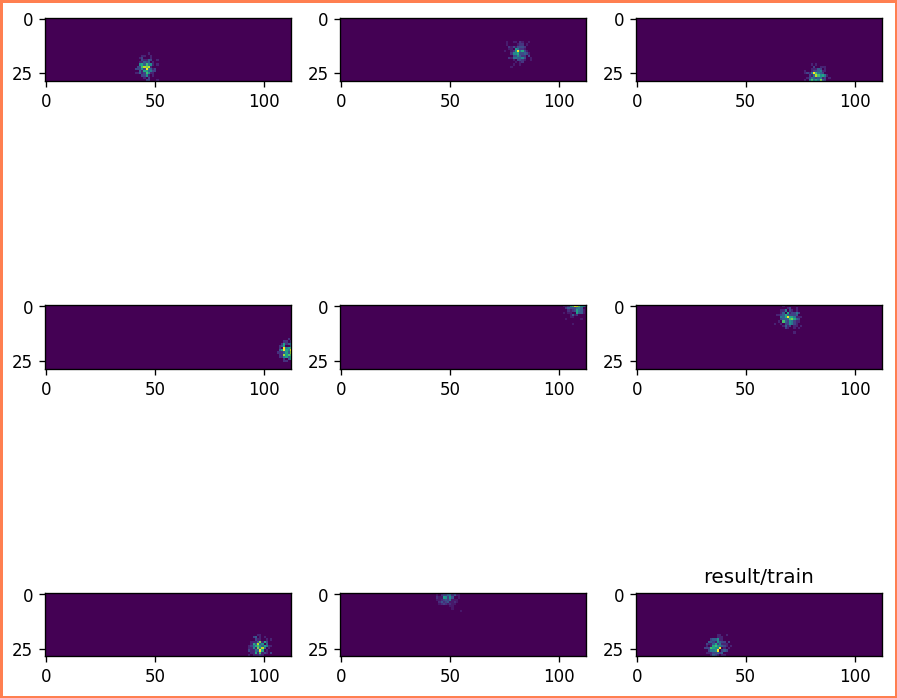

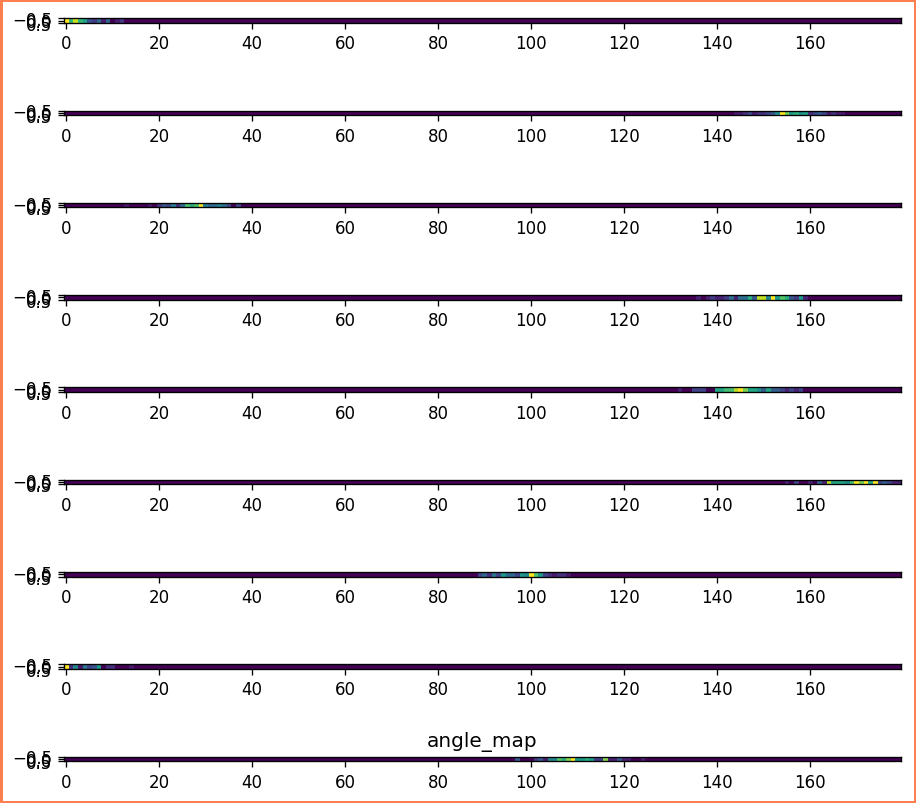

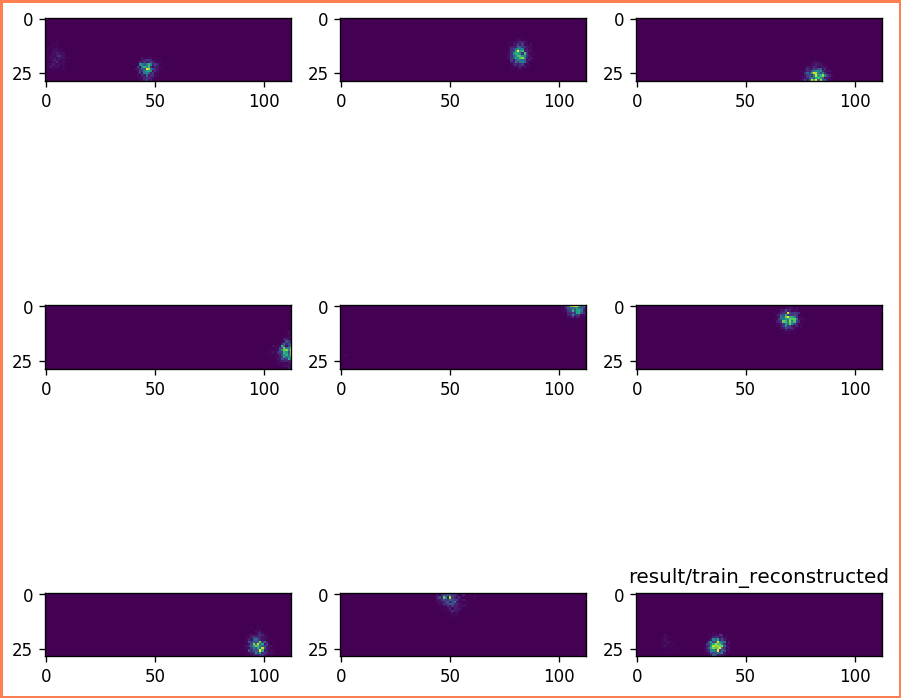

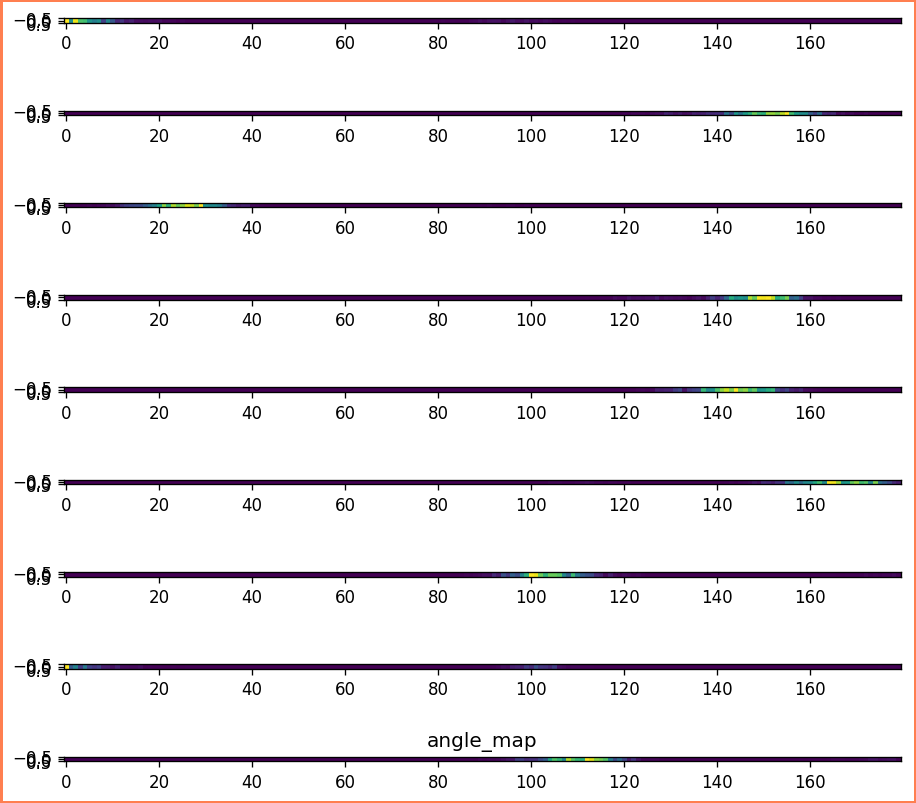

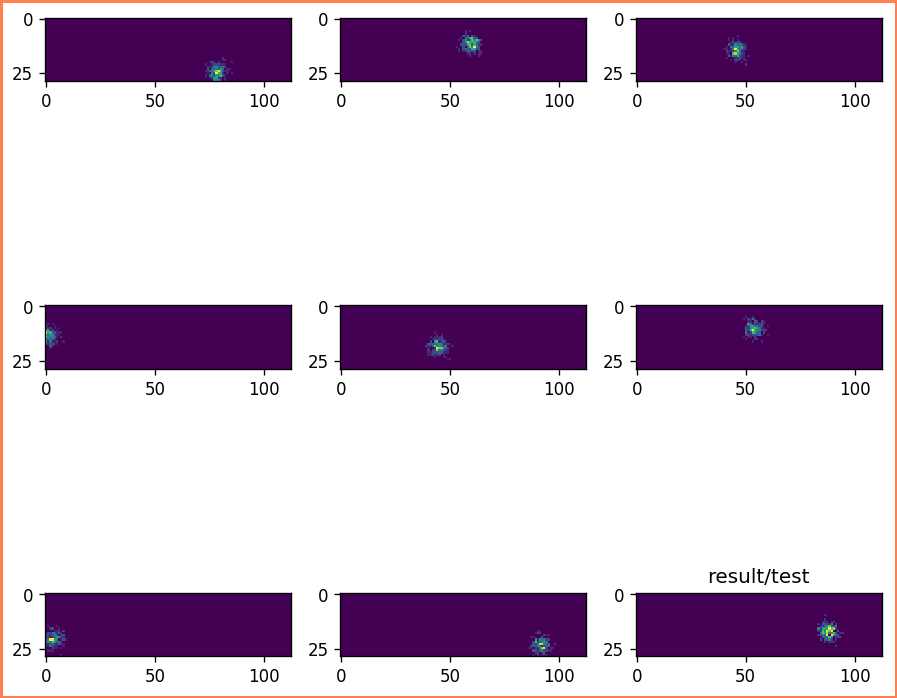

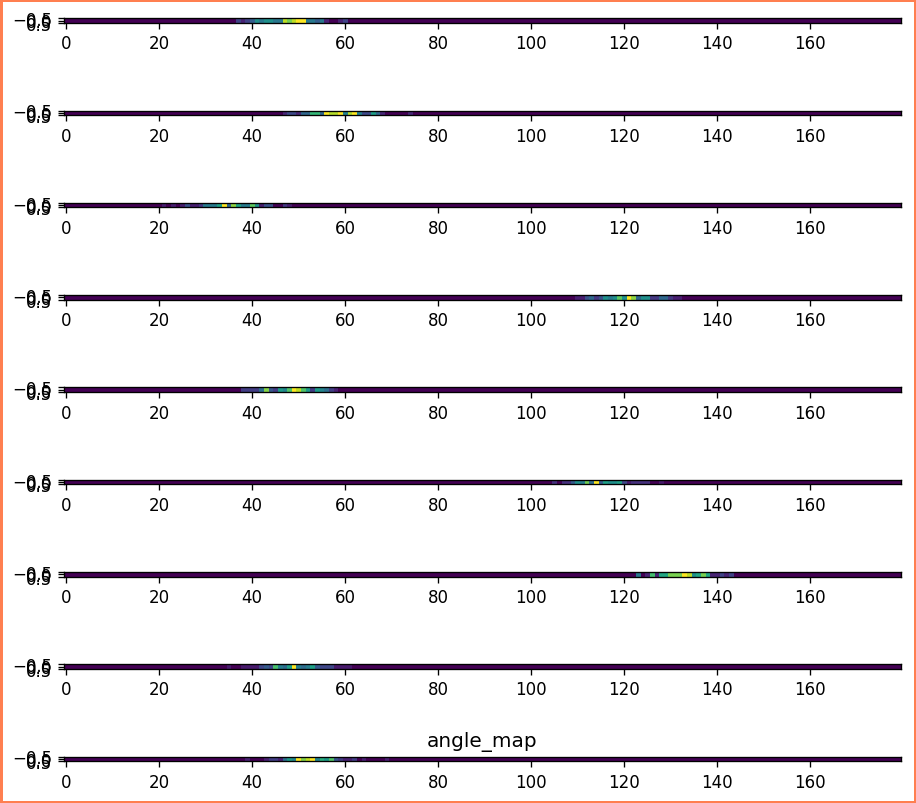

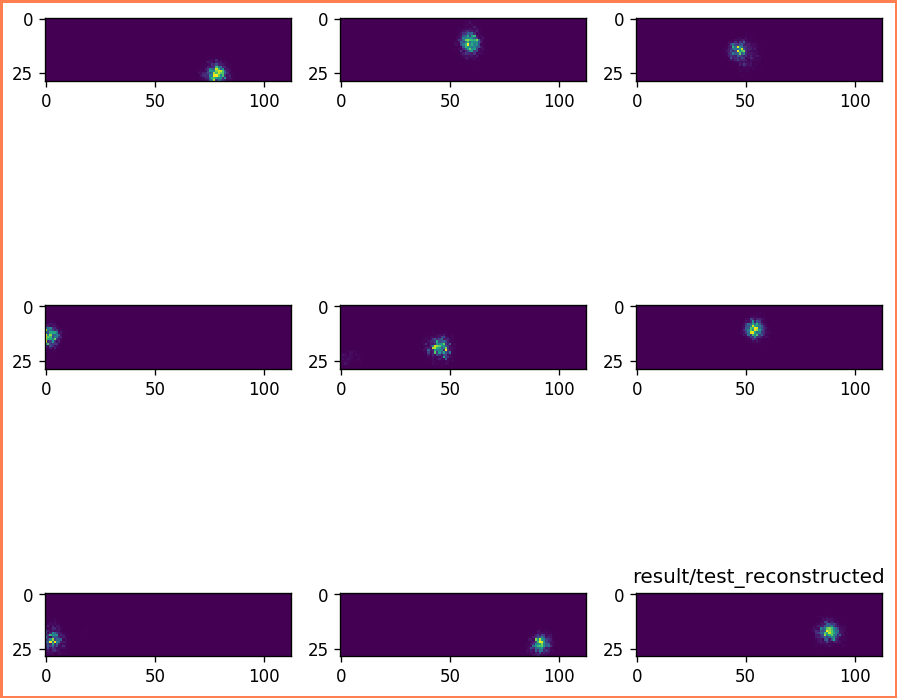

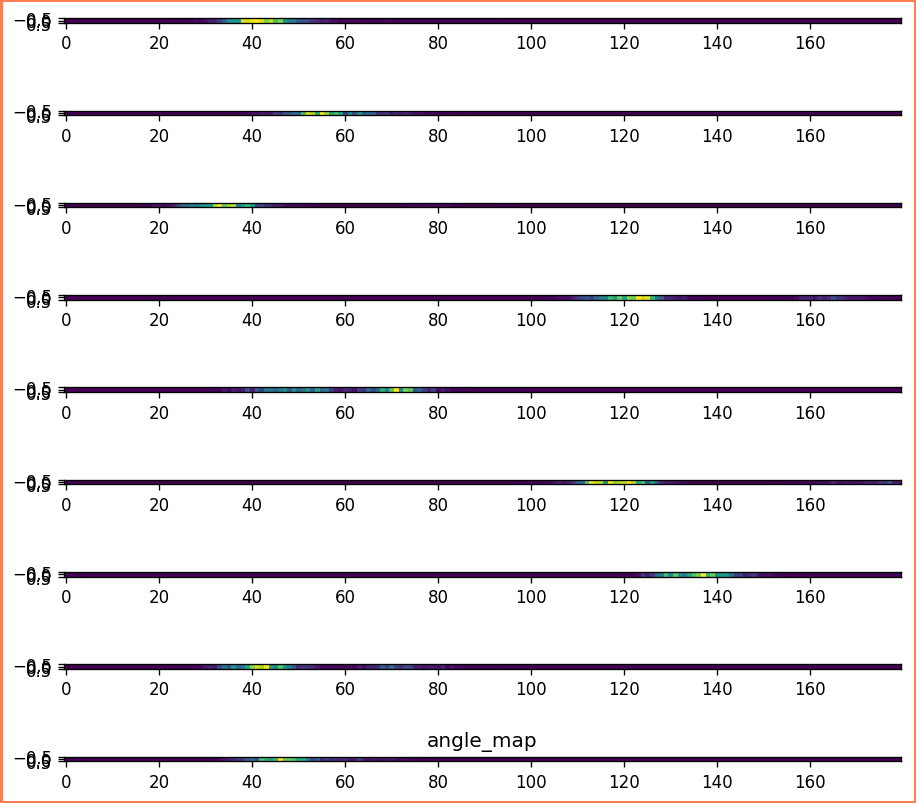

In [6]:
def main():
    global NLABELDIM, NZDIM
    parser = argparse.ArgumentParser(description='Chainer example: VAE')
    parser.add_argument('--initmodel', '-m', default='',
                        help='Initialize the model from given file')
    parser.add_argument('--resume', '-r', default='',
                        help='Resume the optimization from snapshot')
    parser.add_argument('--gpu', '-g', default=-1, type=int,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default='result',
                        help='Directory to output the result')
    parser.add_argument('--epoch', '-e', default=150, type=int,
                        help='number of epochs to learn')
    parser.add_argument('--dimz', '-z', default=4, type=int,
                        help='dimention of encoded vector')
    parser.add_argument('--batchsize', '-b', type=int, default=150,
                        help='learning minibatch size')
    parser.add_argument('--test', action='store_true',
                        help='Use tiny datasets for quick tests')
    args = parser.parse_args(args=['-g 0'])

    print('GPU: {}'.format(args.gpu))
    print('# dim z: {}'.format(args.dimz))
    print('# Minibatch-size: {}'.format(args.batchsize))
    print('# epoch: {}'.format(args.epoch))
    print('')

    #img = '../images/chizu_naga.png'
    img = '../images/field.png'
    dataset = make_random_selfdata.MakeRandomSelfdata(img)    
    global train,test
    #train = dataset.get_random_dataset_for_rcvae_with_2d_onehot(3000)
    #test = dataset.get_random_dataset_for_rcvae_with_2d_onehot(3000)
    #for t in range(10):
    #    dispImage(train[t][1])
    
    #train = dataset.get_random_dataset_for_rcvae_with_2d_onehot_and_sincos(3)
    #test = dataset.get_random_dataset_for_rcvae_with_2d_onehot_and_sincos(3) 
    
    train, debug_data = dataset.get_random_dataset_for_rcvae_with_2d_onehot_and_singhotvec_cosghotvec(3000)
    test, _ = dataset.get_random_dataset_for_rcvae_with_2d_onehot_and_singhotvec_cosghotvec(3000)
    
    maps= list(map(lambda x:x[0], train))
    pos_map, angle_map = separetePosition_and_angle_probabilityMap(maps, len(maps), dataset.onehot_w*dataset.onehot_h )
    print(len(angle_map))
    save_images(pos_map, 'train data kakunin of pos map')
    save_images(angle_map, 'train data kakunin of angle map', h=1, w=dataset.rotation_angle,cols=9,rows=1)
    for n in range(9):
        print('訓練データの画像')
        dispImage(train[n][1])
        posx = debug_data[n][0].astype(np.int64)
        posy = debug_data[n][1].astype(np.int64)
        deg = debug_data[n][2].astype(np.int64)
        print(deg, posx-14, posy-14 , 'deg, posx, posy')
        print('回転する前の画像')
        p_im = dataset.getImage(posx, posy)
        dispImage(np.reshape(p_im,(28,28)))
        print('回転した画像')
        r_im, _ = dataset.getRotateImageAndRad(posx, posy, deg)
        dispImage(np.reshape(r_im,(28,28)))
        
    # Prepare CVAE model, defined in net.py
    NLABELDIM = len(train[0][1])
    CONTEXTDIM = len(train[0][0])
    print('NLABEL', NLABELDIM)
    print('CONDITION', NLABELDIM)
    print('CONTEXT', CONTEXTDIM)
    NZDIM = args.dimz
    
    #print(len(train[0]))
    
    
    
    model = net.MyCVAE(CONTEXTDIM, args.dimz, 900, NLABELDIM)
    model = trainMyModel(model,train,test,args)
    
    train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
    xin = np.empty((0, CONTEXTDIM), np.float32)
    xout = np.empty((0, CONTEXTDIM), np.float32)
    for ind in train_ind:
        x, t = train[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)
    pos_map, angle_map = separetePosition_and_angle_probabilityMap(xin, len(xin), dataset.onehot_w* dataset.onehot_h)
    print(len(angle_map))
    save_images(pos_map, os.path.join(args.out, 'train'))
    save_images(angle_map, 'angle_map', h=1, w=dataset.rotation_angle,cols=9,rows=1)

    pos_map, angle_map = separetePosition_and_angle_probabilityMap(xout, len(xout), dataset.onehot_w* dataset.onehot_h)
    save_images(pos_map, os.path.join(args.out, 'train_reconstructed'))
    save_images(angle_map, 'angle_map', h=1, w=dataset.rotation_angle,cols=9,rows=1)

    test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
    xin = np.empty((0, CONTEXTDIM), np.float32)
    xout = np.empty((0, CONTEXTDIM), np.float32)
    for ind in test_ind:
        x, t = test[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)
    pos_map, angle_map = separetePosition_and_angle_probabilityMap(xin, len(xin), dataset.onehot_w* dataset.onehot_h)
    save_images(pos_map, os.path.join(args.out, 'test'))
    save_images(angle_map, 'angle_map', h=1, w=dataset.rotation_angle,cols=9,rows=1)
    pos_map, angle_map = separetePosition_and_angle_probabilityMap(xout, len(xout), dataset.onehot_w* dataset.onehot_h)
    save_images(pos_map, os.path.join(args.out, 'test_reconstructed'))
    save_images(angle_map, 'angle_map', h=1, w=dataset.rotation_angle,cols=9,rows=1)
    
if __name__ == '__main__':
    main()

# conditionで位置マップを生成するための共通の部分

In [7]:
NZDIM = 4
NLABELDIM = 784 #len(train[0][1])
CONTEXTDIM = 3457 #len(train[0][0])
model = net.MyCVAE(CONTEXTDIM, NZDIM, 900, NLABELDIM)
serializers.load_npz("mymodel_final.npz", model)
# draw images from randomly sampled z
#z = chainer.Variable(np.random.normal(0, 1, (10, NZDIM)).astype(np.float32))
z = chainer.Variable(np.zeros((10, NZDIM), dtype=np.float32))

# Condition(Cropした犬の画像)から位置マップを出力する

(array([0]),)


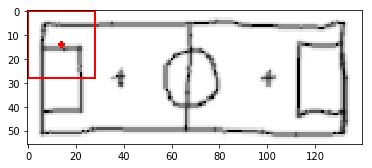

(array([28]),)


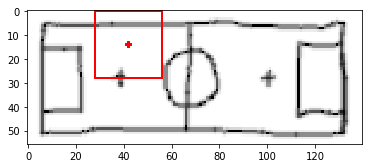

(array([56]),)


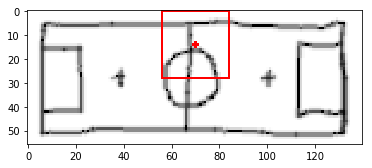

(array([84]),)


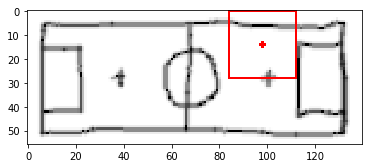

(array([112]),)


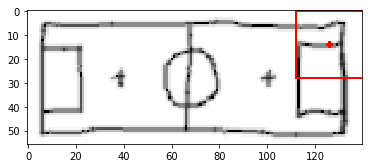

(array([3164]),)


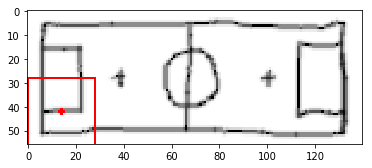

(array([3192]),)


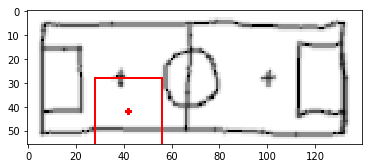

(array([3220]),)


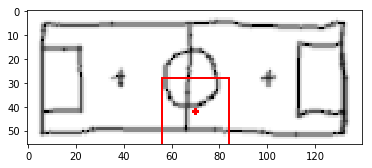

(array([3248]),)


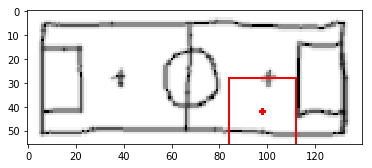

(array([3276]),)


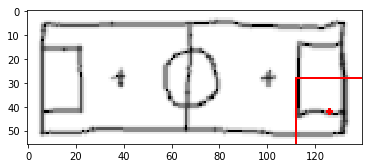

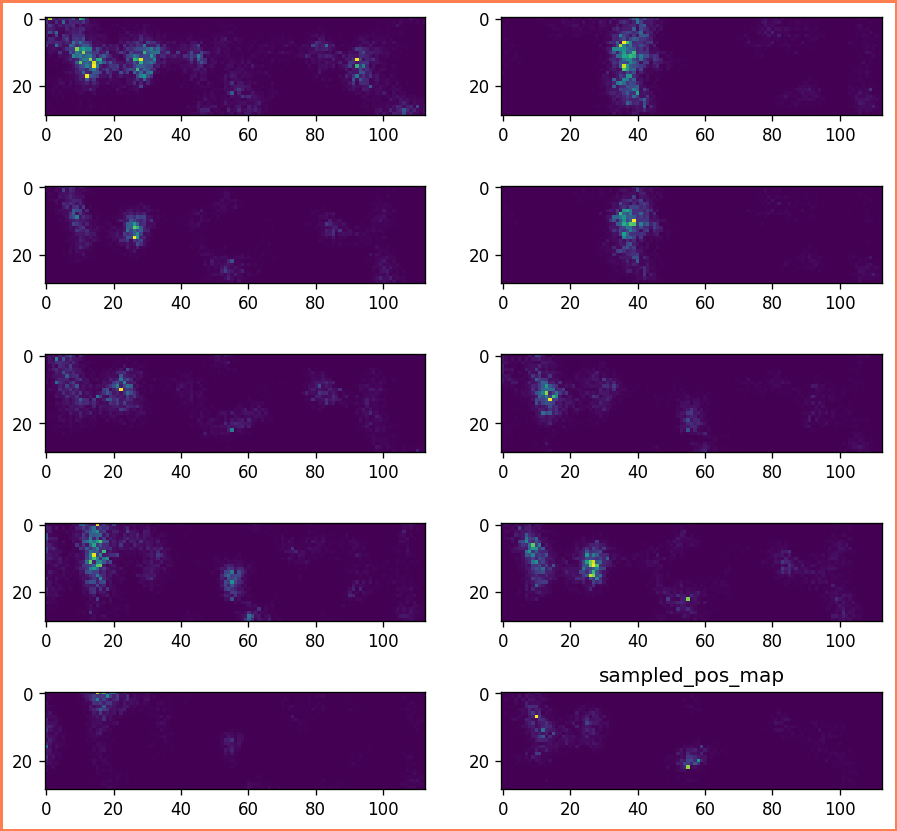

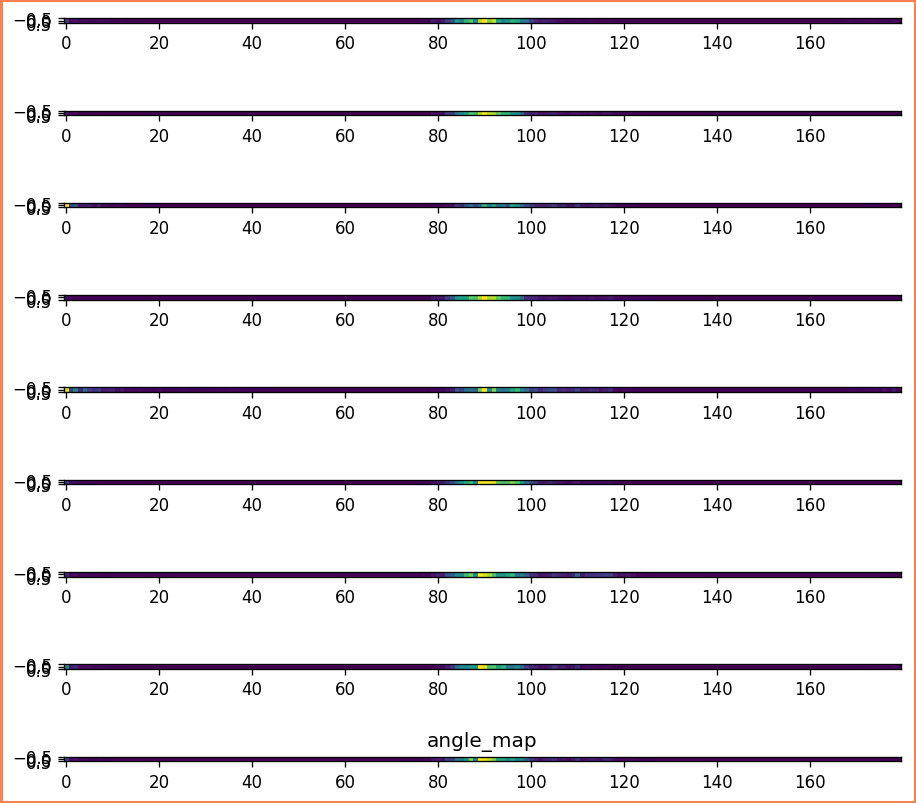

angle_train
0.0 1.0 sin(0), cos(0)
[[0.08532271 0.01657259 0.02775773 ... 0.00358602 0.01656577 0.00153443]
 [0.04842117 0.01670045 0.02159494 ... 0.00116238 0.00499213 0.00178522]
 [0.31198567 0.0586133  0.09152573 ... 0.0021618  0.00720528 0.00120351]
 ...
 [0.24025837 0.03811452 0.06420833 ... 0.00505045 0.01543158 0.00324038]
 [0.12450019 0.02900991 0.0364514  ... 0.00061038 0.00252336 0.00039238]
 [0.10512474 0.0201388  0.03188014 ... 0.00104779 0.00376689 0.00119537]]


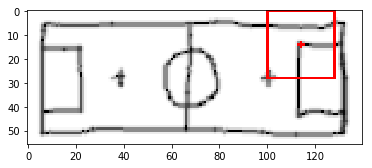

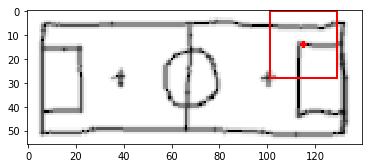

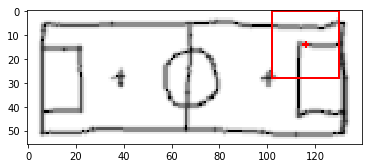

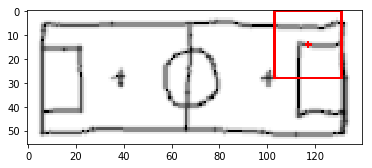

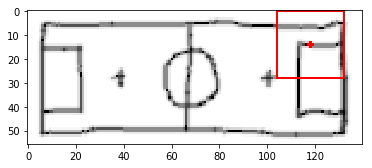

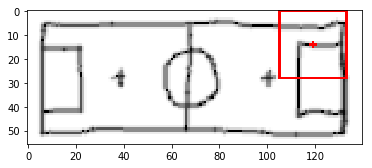

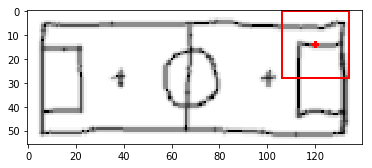

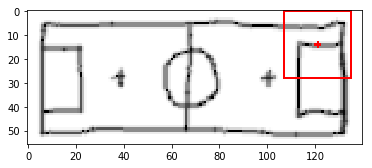

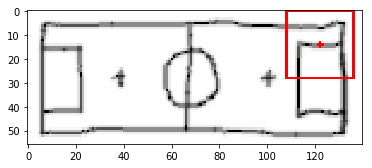

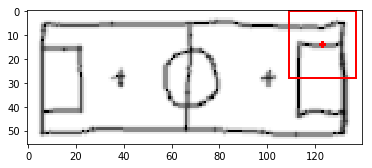

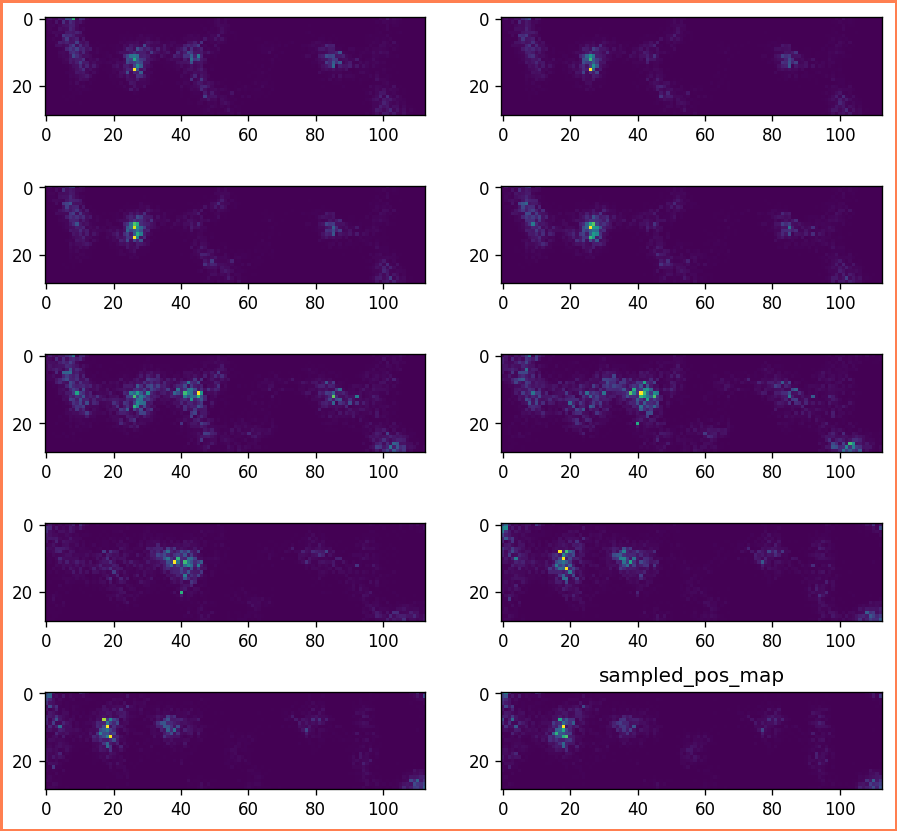

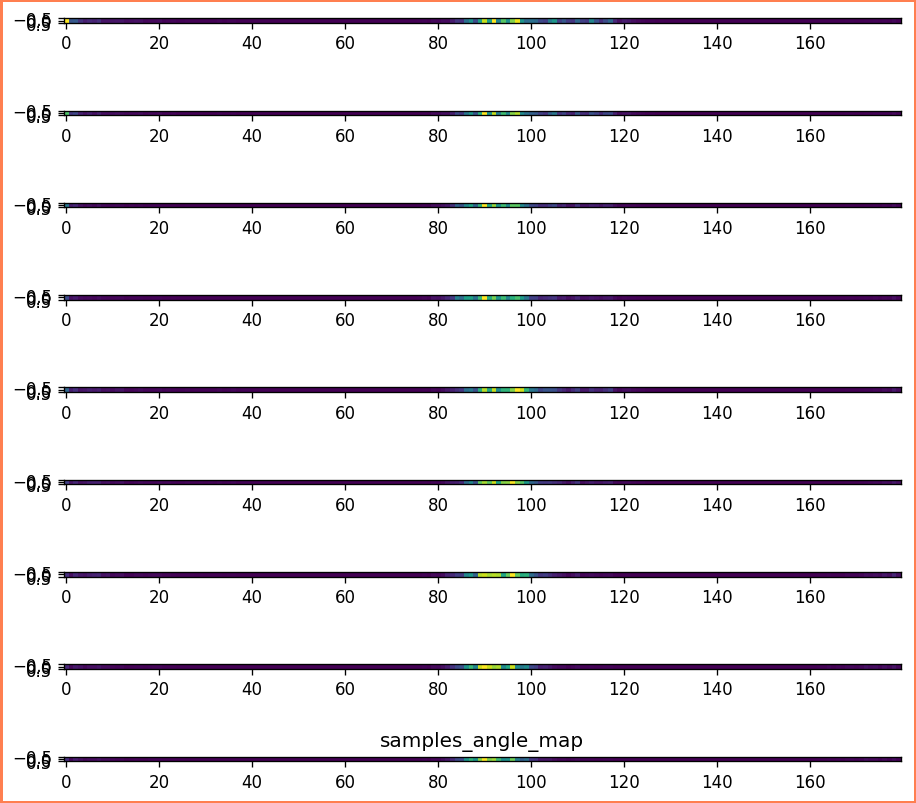

angle_train
0.0 1.0 sin(0), cos(0)
[[0.146577   0.03905436 0.04170847 ... 0.00098652 0.00318515 0.00103697]
 [0.13674468 0.03110459 0.04015198 ... 0.00156614 0.00472331 0.00174436]
 [0.11863759 0.02301478 0.0331845  ... 0.00250798 0.0090079  0.00300768]
 ...
 [0.05320439 0.01214975 0.03163552 ... 0.01009169 0.02439335 0.00836238]
 [0.07388619 0.01415351 0.03977534 ... 0.005674   0.01634672 0.00590706]
 [0.06339151 0.01307905 0.03347579 ... 0.00157791 0.00564563 0.00122985]]


'\nc_img = dataset.cropImage(14,14,28,28)\nplt.imshow(np.reshape(c_img,(28,28)))\nplt.show()\nPoint_symmetrical_img = dataset.flipImage_horizonal_Next2_vartical(c_img,28,28)\nplt.imshow(np.reshape(Point_symmetrical_img,(28,28)))\nplt.show()\n'

In [8]:
#'''
img = '../images/field.png'
t_img = cv2.imread(img)
dataset = make_random_selfdata.MakeRandomSelfdata(img)
onehot_size = dataset.getOnehotSize()
labels = np.zeros((10, onehot_size[0]*onehot_size[1]+dataset.rotation_angle), dtype=np.float32)       # one hot vector
images = np.zeros((10, 28*28), dtype=np.float32)       # condition

#'''
###########画像の中心を見る用#############　
for r in range(2):
    for c in range(5):
        l = dataset.getLabel(28*c+14, 28*r+14)
        print(np.where(l==1))
        i = dataset.getImage(28*c+14, 28*r+14)
        #dispImage(i)
        dispOneHotVec(t_img, l,dataset.getOnehotSize(),dataset.onehot_ratio)
        angle_map = dataset.getLabel_specified_1d(160, dataset.rotation_angle)
        pos_map = dataset.make_gentle_onehot_vec_2d(np.reshape(l, (dataset.onehot_h,dataset.onehot_w)))
        labels[r*5+c, :] = np.concatenate([pos_map, angle_map])
        images[r*5+c, :] = np.reshape(i, 28*28)
values = images
x1 = model.decode(z, np.expand_dims(values, axis=1))
pos_map, angle_map = separetePosition_and_angle_probabilityMap(x1.data, len(x1.data), dataset.onehot_w* dataset.onehot_h)
save_images(pos_map, 'sampled_pos_map',cols=5, rows=2)
save_images(angle_map, 'angle_map', h=1, w=dataset.rotation_angle,cols=9,rows=1)
print('angle_train')
print(np.sin(0), np.cos(0), 'sin(0), cos(0)')
print(angle_map)
#save_onehotvec(x1.data[8])

#'''

#'''###########細かいとこを見る用#############　

s = 100
for i in range(s,s+10):
    l = dataset.getLabel(i+14, 0+14)
    im = dataset.getImage(i+14, 0+14)
    dispOneHotVec(t_img, l,dataset.getOnehotSize(),dataset.onehot_ratio)
    angle_map = dataset.getLabel_specified_1d(0, dataset.rotation_angle)
    pos_map = dataset.make_gentle_onehot_vec_2d(np.reshape(l, (dataset.onehot_h,dataset.onehot_w)))
    labels[r*5+c, :] = np.concatenate([pos_map, angle_map])
    images[i-s, :] = np.reshape(im, 28*28)
values = images
x = model.decode(z, np.expand_dims(values, axis=1))
pos_map, angle_map = separetePosition_and_angle_probabilityMap(x.data, len(x.data), dataset.onehot_w* dataset.onehot_h)
save_images(pos_map, 'sampled_pos_map',cols=5, rows=2)
save_images(angle_map, 'samples_angle_map', h=1, w=dataset.rotation_angle,cols=9,rows=1)

print('angle_train')
print(np.sin(0), np.cos(0), 'sin(0), cos(0)')
print(angle_map)
#'''

'''##########上下左右反転した画像をconditionとして与える#######
for r in range(2):
    for c in range(5):
        l = dataset.getLabel(28*c+14, 28*r+14)
        print(np.where(l==1))
        i = dataset.getImage(28*c+14, 28*r+14)
        dispOneHotVec(t_img, l,dataset.getOnehotSize(),dataset.onehot_ratio)
        dispImage(i)
        Point_symmetrical_img = dataset.flipImage_horizonal_Next2_vartical(i,28,28)
        dispImage(Point_symmetrical_img)
        labels[r*5+c, :] = dataset.make_gentle_onehot_vec_2d(np.reshape(l, (dataset.onehot_h,dataset.onehot_w)))
        images[r*5+c, :] = np.reshape(Point_symmetrical_img, 28*28)
values = images
print(values.shape)
x1 = model.decode(z, np.expand_dims(values, axis=1))
save_images(x1.data, 'sampled',5, 2)
'''
'''
c_img = dataset.cropImage(14,14,28,28)
plt.imshow(np.reshape(c_img,(28,28)))
plt.show()
Point_symmetrical_img = dataset.flipImage_horizonal_Next2_vartical(c_img,28,28)
plt.imshow(np.reshape(Point_symmetrical_img,(28,28)))
plt.show()
'''